<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import requests
import json
import time
import pickle
import pprint
import pandas_profiling
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

Cобираем обучающий датасет

In [6]:
"""
## собираем все названия марок автомобилей
f = open('../input/brand-script/data.txt')
data = json.load(f)
brands = []
for i in data['entities']:
    if(i['count'] > 0):
        brands.append(i['id'])
links = []
time_to_sleep_when_captcha = 5
# по каждой марки авто смотрим страницы с объявлениями и собираем ссылки на эти объявления
for brand in brands:
    print(brand)
    count = 0
    for i in range(1,100):
        url = 'https://auto.ru/moskva/cars/'+brand+'/used/?page='+str(i)
        print(url)
        try:
            response = requests.get(url)
            page = BeautifulSoup(response.text, 'html.parser')
            test_for_link = page.find('a', class_ = 'Link OfferThumb')
            if(test_for_link is None):
                print("No more pages")
                break
            else:
                page_links = page.find_all('a', class_ = 'Link OfferThumb')
                for link in page_links:
                    links.append(link['href'])
        except:
            print("Something wrong")
            time_to_sleep_when_captcha += 1
        time.sleep(time_to_sleep_when_captcha)
# сохраним ссылки в файле
with open('../input/auto-links/links.txt', 'wb') as fp:
    pickle.dump(links, fp)
    """
print('Собрали все линки')

Собрали все линки


В файле "links.txt" сохранили ссылки на объявления. Из за плохой связи приходится задачу разбивать на этапы и сохранять промежуточные результыты.

In [7]:
"""
with open ('../input/auto-links/links.txt', 'rb') as fp:
    links = pickle.load(fp)
print("Всего объявлений: ",len(links))
"""
print("Загрузили ссылки на объявления")

Загрузили ссылки на объявления


In [8]:
"""
# обработаем каждое объявление и соберем датасет для обучения модели
# определим функцию для обработки одного объявления:
def get_auto_data(json_data, page):
    item = []
    item = {
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find('li', class_= 'CardInfoRow_kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find('div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find('li', class_='CardInfoRow_ownersCount').find_all('span')[1].text,
            'ПТС': page.find('li', class_='CardInfoRow_pts').find_all('span')[1].text,
            'Привод': page.find('li', class_='CardInfoRow_drive').find_all('span')[1].text,
            'Руль': page.find('li', class_='CardInfoRow_wheel').find_all('span')[1].text,
            'Состояние': page.find('li', class_='CardInfoRow_state').find_all('span')[1].text,
            'Таможня': page.find('li', class_='CardInfoRow_customs').find_all('span')[1].text,
            'price': page.find('span', class_='OfferPriceCaption__price').text
            }
    return item

time_to_sleep_when_captcha = 0.1
cars_data = []
# для каждой ссылки загрузим страницу, проверим не продана ли машина и обработаем ее функцией get_auto_data
for url in links:
    try:
        response = requests.get(url)
        response.encoding = 'utf-8'
        page = BeautifulSoup(response.text, 'html.parser')
        sold_check = page.find('div', class_ = "CardSold")
        if(sold_check is None):
            json_data = json.loads(page.find('script', type = "application/ld+json").string)
            cars_data.append(get_auto_data(json_data, page))
            print(url, len(cars_data))
        else:
            print("Sold")
    except:
        print('Something is wrong')
        time_to_sleep_when_captcha += 0.1
    time.sleep(time_to_sleep_when_captcha)
# создадим итоговый датафрейм и сохраним его в файле
df = pd.DataFrame(cars_data)
df.to_csv('auto.ru_data.csv', index = False)
"""
print("Собрали датасет для обучения")

Собрали датасет для обучения


Несколько попыток собрать весь датасет в отпуске успехом не увенчались, мобильная связь давала сбой, на текущий момент датасет собирается уже в Москве, на утро понедельника обработано 21 000 объявлений (старт был вечером в воскресение). По этой причине пока использую имеющийся датасет в kaggle от сентября 2020 года, если удастатся собрать свой и останется время, я его заменю. Еще встает проблема инфляции, новый датасет надо будет как то дисконтировать по цене, по грубой оценки процентов на двадцать по некоторым маркам.    

# Setup

In [9]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [10]:
!ls '../input'

auto-links    parsing-all-moscow-auto-ru-09-09-2020
brand-script  sf-dst-car-price-prediction


In [11]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 542.1 KB


## Data Preprocessing

In [13]:
pd.set_option('display.max_columns', 40)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тренировочного датасета:  (89378, 26)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,NaN,240000,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,{'id': '0'},передний,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
# посмотрим на разницу в таблицах по признакам
print('Нет в train - ', set(test.columns) - set(train.columns))
print('Нет в test - ', set(train.columns) - set(test.columns))

Нет в train -  {'vendor', 'priceCurrency', 'car_url', 'equipment_dict', 'sell_id', 'model_info', 'complectation_dict', 'model_name', 'image', 'super_gen', 'parsing_unixtime'}
Нет в test -  {'model', 'hidden', 'price', 'start_date', 'Комплектация'}


In [15]:
# есть разница в названиях, приведем к единому виду:
train.rename(columns = {'Комплектация': 'complectation_dict'}, inplace=True)
train.rename(columns = {'model': 'model_name'}, inplace=True)
# подчистим train от лишнего
train.drop(['name','Состояние','Таможня', 'start_date','hidden'], inplace=True, axis=1)
train = train.drop_duplicates()
train = train.dropna(subset=['price'])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85391 entries, 0 to 89377
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              85390 non-null  object 
 1   brand                 85391 non-null  object 
 2   color                 85391 non-null  object 
 3   fuelType              85391 non-null  object 
 4   modelDate             85390 non-null  float64
 5   numberOfDoors         85390 non-null  float64
 6   productionDate        85391 non-null  int64  
 7   vehicleConfiguration  85390 non-null  object 
 8   vehicleTransmission   85390 non-null  object 
 9   engineDisplacement    85390 non-null  object 
 10  enginePower           85390 non-null  float64
 11  description           82179 non-null  object 
 12  mileage               85391 non-null  int64  
 13  complectation_dict    85391 non-null  object 
 14  Привод                85390 non-null  object 
 15  Руль               

In [16]:
# аналогично для test удалим все лишнее
test.drop(['car_url','equipment_dict','image','name','model_info','parsing_unixtime','priceCurrency','sell_id',
           'super_gen','vendor','Состояние','Таможня'], inplace=True, axis=1)
test['price'] = np.nan # добавим столбец цены
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   complectation_dict    6418 non-null   object 
 4   description           34686 non-null  object 
 5   engineDisplacement    34686 non-null  object 
 6   enginePower           34686 non-null  object 
 7   fuelType              34686 non-null  object 
 8   mileage               34686 non-null  int64  
 9   modelDate             34686 non-null  int64  
 10  model_name            34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  vehicleConfiguration  34686 non-null  object 
 14  vehicleTransmission   34686 non-null  object 
 15  Владельцы          

In [17]:
print('Нет в train - ', set(test.columns) - set(train.columns))
print('Нет в test - ', set(train.columns) - set(test.columns))

Нет в train -  set()
Нет в test -  set()


In [18]:
# можно объединить датасеты, сперва отметив где какой
train['sample'] = 1  
test['sample'] = 0
df = pd.concat([test, train]).reset_index(drop=True)
df.shape

(120077, 22)

In [19]:
#pandas_profiling.ProfileReport(df)

0

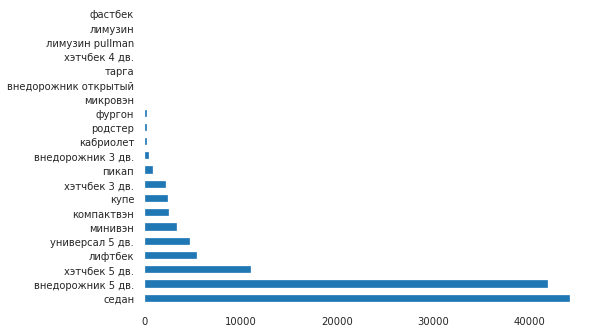

In [20]:
# рассмотрим признаки поближе
import re
num_cols = []
bin_cols = []
cat_cols = []
def to_lower(item):
    if pd.isnull(item):
        return item
    else:
        return item.lower()

# bodyType - слишком много значений, отличающихся прописанием, попробуем сокраить число их число
df['bodyType'] = df['bodyType'].apply(to_lower)
df['bodyType'] = df['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
rename_item = {'седан long':'седан',
               'пикап двойная кабина':'пикап',
               'хэтчбек 3 дв. gtc':'хэтчбек 3 дв.',
               'хэтчбек 5 дв. sportback':'хэтчбек 5 дв.',
               'хэтчбек 5 дв. stepway':'хэтчбек 5 дв.',
               'пикап двойная кабина double cab':'пикап',
               'внедорожник 5 дв. prime':'внедорожник 5 дв.',
               'минивэн grand':'минивэн',
               'внедорожник 5 дв. cooper s':'внедорожник 5 дв.',
               'пикап двойная кабина crew cab':'пикап',
               'внедорожник 5 дв. cooper s':'внедорожник 5 дв.',
               'внедорожник 5 дв. long':'внедорожник 5 дв.',
               'минивэн l2':'минивэн',
               'хэтчбек 3 дв. cooper s':'хэтчбек 3 дв.'
              }
df = df.replace({'bodyType': rename_item})
def match_type(bodyType, search_type):
    if(re.match(search_type, bodyType)):
        return search_type
    else:
        return bodyType

df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('минивэн',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('универсал 5 дв.',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('хэтчбек 5 дв.',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('седан',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('пикап',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('купе',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('купе',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('купе',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('лифтбек',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('хэтчбек 3 дв.',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('компактвэн',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('внедорожник 3 дв.',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('внедорожник 5 дв.',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('фургон',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('тарга',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('кабриолет',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('родстер',))
df['bodyType'] = df['bodyType'].astype(str).apply(match_type, args=('микровэн',))
df['bodyType'] = df['bodyType'].astype(str).apply(lambda x: 'седан' if x == 'nan' else x)

df.bodyType.value_counts().plot.barh()
cat_cols.append('bodyType')
df.bodyType.isna().sum()

In [21]:
cat_cols.append('brand')
df.brand.value_counts()

MERCEDES      11791
BMW           11429
VOLKSWAGEN    11210
NISSAN         9709
TOYOTA         8476
AUDI           7212
MITSUBISHI     6042
HYUNDAI        5543
KIA            5486
SKODA          5429
FORD           4763
CHEVROLET      3588
VOLVO          3455
OPEL           3092
RENAULT        2682
HONDA          2313
MAZDA          2278
INFINITI       1886
LEXUS          1860
PEUGEOT        1603
LAND_ROVER     1565
CITROEN        1120
DAEWOO         1028
SUBARU          927
SUZUKI          842
SSANG_YONG      707
PORSCHE         699
CHERY           559
JEEP            456
GREAT_WALL      416
DODGE           412
CADILLAC        317
CHRYSLER        316
MINI            303
JAGUAR          294
GEELY           269
Name: brand, dtype: int64

In [22]:
df.color.value_counts()

040001         23929
FAFBFB         14842
чёрный         11010
CACECB         10997
97948F         10332
0000CC          8456
белый           6133
EE1D19          4427
серебристый     4113
серый           3984
200204          3408
синий           3289
007F00          2522
C49648          1813
красный         1531
коричневый      1501
22A0F8          1358
зелёный          952
DEA522           765
660099           738
FFD600           692
бежевый          639
4A2197           596
FF8649           491
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
FFC0CB            25
розовый           13
Name: color, dtype: int64

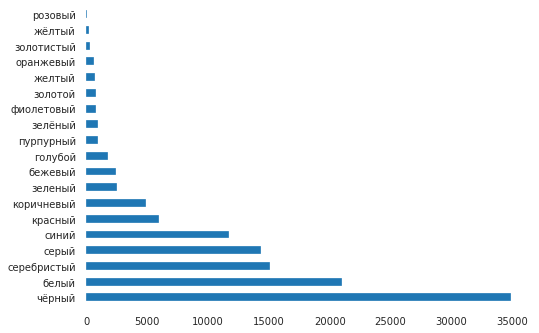

In [23]:
# надо привести цвета к единым значениям
rename_color = {
    '0000CC': 'синий',
    '200204': 'коричневый',
    'EE1D19': 'красный',
    '007F00': 'зеленый',
    '040001': 'чёрный',
    'FAFBFB': 'белый',
    'CACECB': 'серебристый',
    '97948F': 'серый',
    'FFD600': 'желтый',
    'FF8649': 'оранжевый',
    'FFC0CB': 'розовый',
    'C49648': 'бежевый',
    '22A0F8': 'голубой',
    '660099': 'пурпурный',
    'DEA522': 'золотой',
    '4A2197': 'фиолетовый',
    'FFD600': 'желтый',
    'FF8649': 'оранжевый',
    'FFC0CB': 'розовый'
}
df = df.replace({'color': rename_color})
cat_cols.append('color')
df.color.value_counts().plot.barh()

In [24]:
# признак description: можно сделать признак есть/нет или его длинну. Из текста еще можно попробовать понять продает салон или физ. лицо, это если успею  
df['description_length'] = df.description.apply(lambda x: len(str(x)))
df = df.drop('description',axis=1)
num_cols.append('description_length')

In [25]:
df.engineDisplacement.value_counts()

1.6          16517
2.0          12115
2.0 LTR       7391
1.4           5414
1.8           5051
             ...  
Brawny           1
3.9d             1
N46              1
Донинвест        1
3.5d             1
Name: engineDisplacement, Length: 589, dtype: int64

In [26]:

# преобразуем признаки engineDisplacement и enginePower 
df['engineDisplacement'] = df['engineDisplacement'].astype(str)
df['engineDisplacement'] = df['engineDisplacement'].str.extract('(\d.\d)', expand = False).str.strip()
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: None if float(x) > 10 else x)

df['enginePower'] = df['enginePower'].astype(str).apply(lambda x: x.split()[0])
df['enginePower'] = df['enginePower'].astype(float)
df['enginePower'].fillna(df['enginePower'].median(), inplace = True) # изменим одну строку где пустое поле enginePower


In [27]:
df['engineDisplacement'] = df['engineDisplacement'].astype(str)
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: float(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120077 entries, 0 to 120076
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              120077 non-null  object 
 1   brand                 120077 non-null  object 
 2   color                 120077 non-null  object 
 3   complectation_dict    91809 non-null   object 
 4   engineDisplacement    99972 non-null   float64
 5   enginePower           120077 non-null  float64
 6   fuelType              120077 non-null  object 
 7   mileage               120077 non-null  int64  
 8   modelDate             120076 non-null  float64
 9   model_name            120077 non-null  object 
 10  numberOfDoors         120076 non-null  float64
 11  productionDate        120077 non-null  int64  
 12  vehicleConfiguration  120076 non-null  object 
 13  vehicleTransmission   120076 non-null  object 
 14  Владельцы             109542 non-null  object 
 15  

engineDisplacement пропусков:  20105


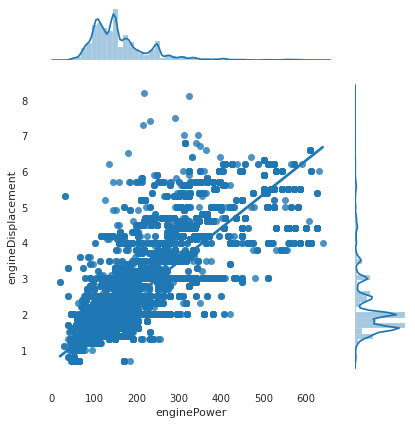

In [28]:
print("engineDisplacement пропусков: ",df.engineDisplacement.isna().sum())
import seaborn as sns
sns.jointplot(x='enginePower', y='engineDisplacement', data=df, kind='reg')


In [29]:
# имеем хорошую корреляцию между эти двумя признаками, что логично, 
# можно использовать мощность для заполнения пропущенных значений объема двигателя
def fill_engineDisplacement(displacement, power):
    if(displacement < 1 and power > 400):
        displacement = 5.5
    elif(displacement < 1 and power < 100):
        displacement = 1.0
    else:
        pass
    return displacement
df['engineDisplacement'].fillna(df.groupby(['enginePower'])['engineDisplacement'].transform('median'), inplace=True)
df['engineDisplacement'].fillna(0.0, inplace = True)
df['engineDisplacement'] = df.apply(lambda x: fill_engineDisplacement(x['engineDisplacement'], x['enginePower']), axis = 1)


In [30]:
cat_cols.append('engineDisplacement')
num_cols.append('enginePower')

In [31]:
df = df.replace({'fuelType': {'универсал' : 'бензин'}}) # заменим единственный вброс 'универсал'
df.fuelType.value_counts()
df.fuelType.isna().sum() # пустых значений нет
cat_cols.append('fuelType')

In [32]:
# приведем значения к одному виду
df['Владельцы'] = df['Владельцы'].apply(lambda x: x if type(x) == float else int(x[0]))
df['Владельцы'].value_counts()

3.0    51819
2.0    30033
1.0    27690
Name: Владельцы, dtype: int64

In [33]:
cat_cols.append('Владельцы')

In [34]:
df['mileage'].value_counts()
# значений очень много, надо разбить на группы и сделать более наглядный признак
df['mileage'].describe()
step = np.arange(0, 1000000, 50000)
df.groupby(pd.cut(df.mileage, step)).Владельцы.median()

mileage
(0, 50000]          1.0
(50000, 100000]     2.0
(100000, 150000]    2.0
(150000, 200000]    3.0
(200000, 250000]    3.0
(250000, 300000]    3.0
(300000, 350000]    3.0
(350000, 400000]    3.0
(400000, 450000]    3.0
(450000, 500000]    3.0
(500000, 550000]    3.0
(550000, 600000]    3.0
(600000, 650000]    3.0
(650000, 700000]    3.0
(700000, 750000]    3.0
(750000, 800000]    3.0
(800000, 850000]    3.0
(850000, 900000]    3.0
(900000, 950000]    2.5
Name: Владельцы, dtype: float64

In [35]:
# получается с одной стороны разбить пробег на три части, плюс наглядно видна тенденция по числу владельцев в ПТС
mileage_points = [0, 75000, 175000, 1000000]
df["mileage_points"] = df["mileage"].apply(lambda x: 3 if x>=175000 else(2 if x>=75000 else(1 if x>=5000 else 0)))
owners = [1, 2, 3]
# заполним пропуски у признака "Владельцы"
df['temp_'] = pd.cut(df['mileage'], bins = mileage_points, labels = owners, include_lowest = True)
df['Владельцы'] = df['Владельцы'].fillna(df['temp_']) 
df = df.drop('temp_', axis = 1)
df['Владельцы'] = df['Владельцы'].apply(lambda x: int(x))
num_cols.append('mileage')
cat_cols.append('mileage_points')
cat_cols.append('Владельцы')


In [36]:
# следующие признаки это даты выпуска и дата выхода модели, сними легче работать в виде разницы от текущего года
df.productionDate.value_counts()
df.modelDate.value_counts()
df['prod_age'] = 2021 - df.productionDate
num_cols.append('productionDate')
num_cols.append('prod_age')
df['modelDate'] = df['modelDate'].fillna(df['modelDate'].median())
df['model_age'] = 2021 - df.modelDate
num_cols.append('modelDate')
num_cols.append('model_age')


In [37]:
df.modelDate.isna().sum()

0

In [38]:
# тут все ок, пустых нет
df['model_name'].isna().sum()
cat_cols.append('model_name')
df.numberOfDoors.value_counts()
cat_cols.append('numberOfDoors')
df.vehicleTransmission.value_counts()

AUTOMATIC           47243
MECHANICAL          24898
автоматическая      19596
ROBOT                7348
механическая         7209
VARIATOR             5901
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

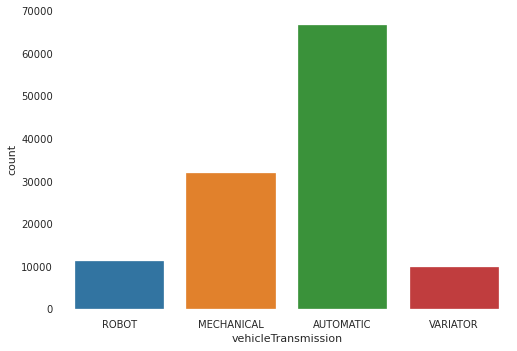

In [39]:
# приведем признак vehicleTransmission к единым значениям
change_transmission = {
               'автоматическая': 'AUTOMATIC',
               'механическая': 'MECHANICAL',
               'вариатор': 'VARIATOR',
               'роботизированная': 'ROBOT'
                }
df = df.replace({'vehicleTransmission': change_transmission})
df.vehicleTransmission = df.vehicleTransmission.fillna('AUTOMATIC')
cat_cols.append('vehicleTransmission')
sns.countplot(x = 'vehicleTransmission', data = df)

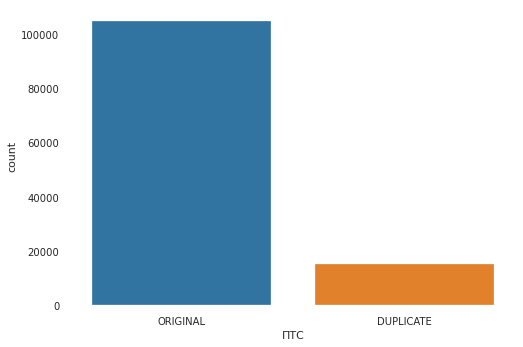

In [40]:
# аналогично с признаком ПТС
change_passport = {
               'Оригинал': 'ORIGINAL',
               'Дубликат': 'DUPLICATE'
                }
df = df.replace({'ПТС': change_passport})
df.ПТС = df.ПТС.fillna('DUPLICATE') # в случае если оригинал, то его скорее укажут, чем пропустят
cat_cols.append('ПТС')
sns.countplot(x = 'ПТС', data = df)

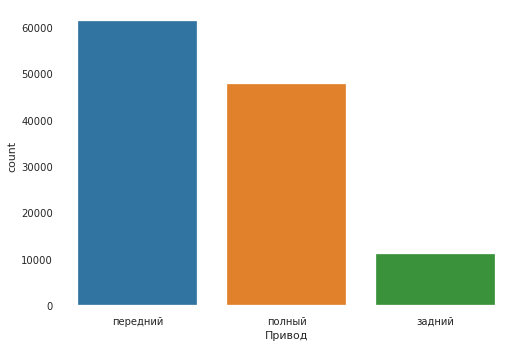

In [41]:
df.Привод.value_counts()
df.Привод = df.Привод.fillna('передний')
sns.countplot(x = 'Привод', data = df)
cat_cols.append('Привод')

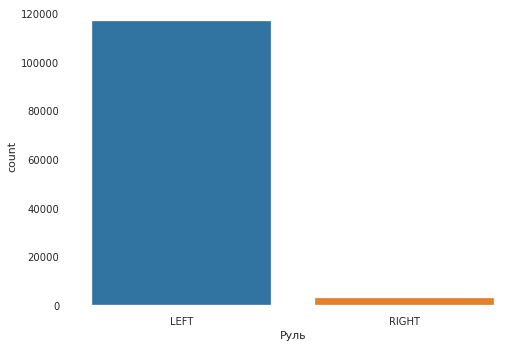

In [42]:
change_wheel = {
               'Левый': 'LEFT',
               'Правый': 'RIGHT'
                }
df = df.replace({'Руль': change_wheel})
cat_cols.append('Руль')
sns.countplot(x = 'Руль', data = df)

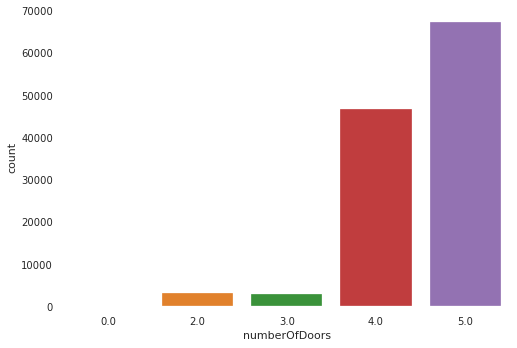

In [43]:
df.numberOfDoors.isna().sum() # одно пустое значение, заменим его на 5, как наиболее частое
df.numberOfDoors = df.numberOfDoors.fillna(5)
sns.countplot(x = 'numberOfDoors', data = df)
cat_cols.append('numberOfDoors')

In [44]:
df.numberOfDoors.isna().sum()

0

In [45]:
df.Владение.value_counts()

{'year': 2018, 'month': 10}    492
{'year': 2019, 'month': 8}     491
{'year': 2018, 'month': 8}     486
{'year': 2018, 'month': 9}     470
{'year': 2018, 'month': 11}    470
                              ... 
20 лет и 5 месяцев               1
{'year': 1977, 'month': 12}      1
19 лет и 7 месяцев               1
42 года и 10 месяцев             1
16 лет и 5 месяцев               1
Name: Владение, Length: 565, dtype: int64

In [46]:
# complectation_dict - хороший признак, влияет на цену, но его надо как то распарсить, 
# чтобы он заработал, удаляем пока, также как и признак vehicleConfiguration
# из-за больших пропусков в признаке Владение его удаляем
df.drop(['complectation_dict', 'vehicleConfiguration', 'Владение'], axis=1, inplace=True)


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120077 entries, 0 to 120076
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   bodyType             120077 non-null  object  
 1   brand                120077 non-null  object  
 2   color                120077 non-null  object  
 3   engineDisplacement   120077 non-null  float64 
 4   enginePower          120077 non-null  float64 
 5   fuelType             120077 non-null  object  
 6   mileage              120077 non-null  int64   
 7   modelDate            120077 non-null  float64 
 8   model_name           120077 non-null  object  
 9   numberOfDoors        120077 non-null  float64 
 10  productionDate       120077 non-null  int64   
 11  vehicleTransmission  120077 non-null  object  
 12  Владельцы            120077 non-null  category
 13  ПТС                  120077 non-null  object  
 14  Привод               120077 non-null  object  
 15  

['description_length', 'enginePower', 'mileage', 'productionDate', 'prod_age', 'modelDate', 'model_age']


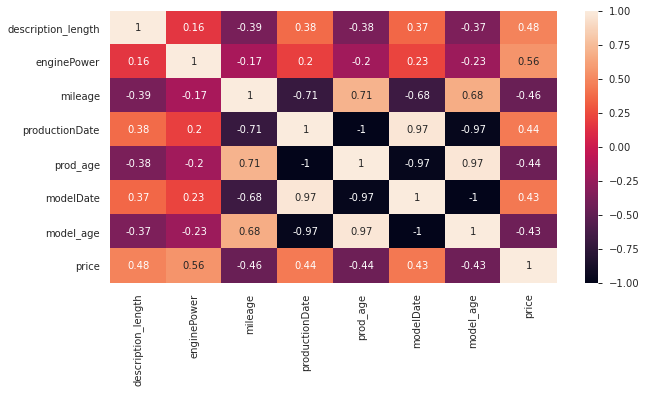

In [48]:
# посмотрим на корреляцию числовых признаков и цены
print(num_cols)
plt.figure(figsize=(10,5))
sns.heatmap(df[num_cols + ['price']].corr(), annot = True)

In [49]:
for colum in ['bodyType',
 'brand',
 'color',
 'mileage_points',
 'Владельцы',
 'model_name',
 'numberOfDoors',
 'vehicleTransmission',
 'ПТС',
 'Привод',
 'Руль',
 'numberOfDoors',
 'engineDisplacement',
 'fuelType',
 'Владельцы']:
    df[colum] = df[colum].astype('category').cat.codes

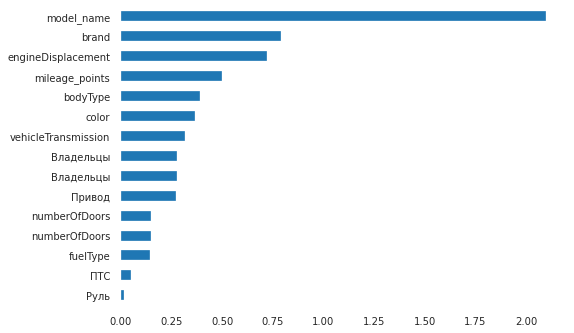

In [50]:
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
temp_df = df[df['sample'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols], temp_df['price'], discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind='barh')
# проанализируем значимость категориальных признаков

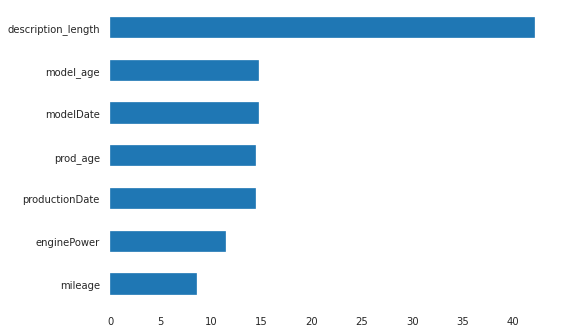

In [51]:
imp_num = Series(f_classif(temp_df[num_cols], temp_df['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
# проанализируем числовые признаки

In [52]:
# по ходу модели ругаются на русские символы, приведем названия столбцов в нормальный вид
df.rename(columns={'bodyType': 'body_type',
                   'engineDisplacement': 'engine_displacement',
                   'enginePower': 'engine_power',
                   'fuelType': 'fuel_type',
                   'modelDate': 'model_date',
                   'numberOfDoors': 'number_of_doors',
                   'productionDate': 'production_date',
                   'vehicleTransmission': 'vehicle_transmission',
                   'Владельцы': 'owners',
                   'ПТС': 'passport',
                   'Привод': 'drive',
                   'Руль': 'wheel'
                   }, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120077 entries, 0 to 120076
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             120077 non-null  int8   
 1   brand                 120077 non-null  int8   
 2   color                 120077 non-null  int8   
 3   engine_displacement   120077 non-null  int8   
 4   engine_power          120077 non-null  float64
 5   fuel_type             120077 non-null  int8   
 6   mileage               120077 non-null  int64  
 7   model_date            120077 non-null  float64
 8   model_name            120077 non-null  int16  
 9   number_of_doors       120077 non-null  int8   
 10  production_date       120077 non-null  int64  
 11  vehicle_transmission  120077 non-null  int8   
 12  owners                120077 non-null  int8   
 13  passport              120077 non-null  int8   
 14  drive                 120077 non-null  int8   
 15  

## Train Split

In [53]:
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample','price'], axis=1)
X = train_df.drop(['price'], axis=1)
y = train_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)


In [54]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             34686 non-null  int8   
 1   brand                 34686 non-null  int8   
 2   color                 34686 non-null  int8   
 3   engine_displacement   34686 non-null  int8   
 4   engine_power          34686 non-null  float64
 5   fuel_type             34686 non-null  int8   
 6   mileage               34686 non-null  int64  
 7   model_date            34686 non-null  float64
 8   model_name            34686 non-null  int16  
 9   number_of_doors       34686 non-null  int8   
 10  production_date       34686 non-null  int64  
 11  vehicle_transmission  34686 non-null  int8   
 12  owners                34686 non-null  int8   
 13  passport              34686 non-null  int8   
 14  drive                 34686 non-null  int8   
 15  wheel              

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [55]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [56]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engine_displacement'].map(tmp_train.groupby('engine_displacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

# Точность наивной модели по метрике MAPE: 82.87%

Точность наивной модели по метрике MAPE: 82.87%


Модель №1

In [57]:
# можно посмотреть простую модель линейной регрессии
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# уже лучше - Точность модели по метрике MAPE: 29.76%

Точность модели по метрике MAPE: 29.76%


Модель №2

In [58]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True
         )

model.save_model('catboost_single_model_baseline.model')
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# Точность модели по метрике MAPE: 14.93%

Точность модели по метрике MAPE: 14.93%


In [59]:
# попробуем подобрать параметры 
cb = CatBoostRegressor(iterations = 20000,
                       learning_rate = 0.15,
                       depth = 9,
                       random_seed = RANDOM_SEED,
                       eval_metric = 'MAPE',
                       custom_metric = ['R2', 'MAE'],
                       silent=True
                       )
model.fit(X_train, y_train,
         eval_set = (X_test, y_test),
         verbose_eval = 0,
         use_best_model = True
         )

model.save_model('catboost_single_model_baseline.model')
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# Точность модели по метрике MAPE: 14.93%

Точность модели по метрике MAPE: 14.93%


Модель 3 - попробуем уменьшить влияние выбросов с помощью логарифма

In [60]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
# Точность модели по метрике MAPE: 12.52%
# predict_submission = np.exp(model.predict(test_df)) # kaggle v.9 13.2382

Точность модели по метрике MAPE: 12.52%


Модель №4

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(min_samples_split = 2,
                               learning_rate = 0.03,
                               max_depth = 10,
                               n_estimators = 1000)
gb.fit(X_train, y_train)
predict = gb.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# Точность модели по метрике MAPE: 13.42%

Точность модели по метрике MAPE: 13.44%


Модель №4 с подбором параметров

In [62]:
# очень долго работает, каждый раз не запускаем
from sklearn.model_selection import GridSearchCV
max_depth = [5,10,15]
n_estimators = [100, 200, 1000]
hyperparameters = dict(max_depth = max_depth, n_estimators = n_estimators)
#model = GradientBoostingRegressor()
#model.fit(X_train, y_train)
#clf = GridSearchCV(model, hyperparameters)
#best_model = clf.fit(X_train, y_train)
#print('max_depth: ', best_model.best_estimator_.get_params()['max_depth'])
#print('n_estimators: ', best_model.best_estimator_.get_params()['n_estimators'])


Модель №5

In [63]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           max_depth = 15,
                           max_features = 'log2',
                           random_state = RANDOM_SEED,
                           oob_score = True)
rfr.fit(X_train, y_train)
predict = rfr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# Точность модели по метрике MAPE: 16.22%

Точность модели по метрике MAPE: 16.22%


Модель №6

In [64]:
from lightgbm import LGBMRegressor
lgbmr = LGBMRegressor(objective = 'regression', 
                      max_depth = 10,
                      num_leaves = 500,
                      learning_rate = 0.05,
                      n_estimators = 10000,
                      metric = 'mape',
                      feature_fraction = 0.6
                      )
lgbmr.fit(X_train, y_train)
predict = lgbmr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

# Точность модели по метрике MAPE: 16.30%

Точность модели по метрике MAPE: 16.30%


Модель №7

In [65]:
from sklearn.ensemble import StackingRegressor
estimators = [('lgbmr', LGBMRegressor(objective = 'regression', 
                                      max_depth = 10, 
                                      num_leaves = 500,
                                      learning_rate = 0.02, 
                                      n_estimators = 100, 
                                      metric = 'mape',
                                      feature_fraction = 0.6
                                     )
              ),
              ('gbr', GradientBoostingRegressor(min_samples_split = 2,
                                                learning_rate = 0.03,
                                                max_depth = 10,
                                                n_estimators = 100
                                               )
              )]

stack = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())
stack.fit(X_train, np.log(y_train))
predict_e = np.exp(stack.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

# Точность модели по метрике MAPE: 13.66%
# predict_submission = np.round(np.exp(stack.predict(test_df)),-3).astype('int') # Your submission scored 14.50850 


Точность модели по метрике MAPE: 13.66%


Модель №8

In [66]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(objective = 'reg:squarederror',
                        colsample_bytree = 0.5,
                        learning_rate = 0.02,
                        max_depth = 10,
                        alpha = 1,
                        n_jobs = -1,
                        n_estimators = 1000
                       )
xgbr.fit(X_train, np.log(y_train + 1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xgbr.predict(X_test))))*100:0.2f}%")

# Точность модели по метрике MAPE: 12.27%

Точность модели по метрике MAPE: 12.27%


In [67]:
predict_submission = np.exp(xgbr.predict(test_df))
# Your submission scored 12.68488, which is an improvement of your previous score of 13.23820.

# Submission

In [68]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index = False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.140439e+05
1,1100549428,9.052058e+05
2,1100658222,8.767750e+05
3,1100937408,6.961381e+05
4,1101037972,6.872599e+05
5,1100912634,7.599797e+05
6,1101228730,6.314958e+05
7,1100165896,4.097266e+05
8,1100768262,1.644924e+06
9,1101218501,7.917218e+05


Получилось, что из 8 моделей, xgboost дал наилучший результат 